In [26]:
import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import pandas as pd
import pickle
from scipy.optimize import fsolve
from multiprocessing import Pool
from collections import ChainMap
%matplotlib inline  

In [27]:
#given the number of pods K, it returns the list of nodes indexed as [server,edge,aggregation,core] 
#and the list of links as [[indexSourceNode,indexTargetNode]]
####################################################################################################
#NB: in python 3 int/int yields float. In order to avoid problems with idexes 
#(which need to be integers), use int//int to produce int in output (it actually performs floor(a/b)) 
#####################################################################################################
def getFatTree(K):
    N_core = (K//2)**2
    N_aggr = (K**2)//2
    N_edge = N_aggr
    N_serv = N_edge * K//2
    N_tot = N_core + N_aggr + N_edge + N_serv
    
    serv_nodes = np.arange(N_serv)
    edge_nodes = N_serv + np.arange(N_edge)
    aggr_nodes = N_serv + N_edge + np.arange(N_aggr)
    core_nodes = N_serv + N_edge + N_aggr + np.arange(N_core)

    Adj =np.matrix(np.zeros((N_tot,N_tot)))
    n_core_connected = np.zeros(N_aggr)
    
    #aggregation to edge
    for k in range(K):#% k-th pod
        a=N_serv+N_edge+k*K//2#starting index aggregation nodes
        b=N_serv+k*K//2#starting index edge nodes
        Adj[a:a+K//2,b:b+K//2] = np.ones((K//2,K//2))
        
    #edge to servers
    for e in range(N_edge):
        a=N_serv+e#starting index edge nodes
        b=e*K//2#starting index connected servers
        Adj[a,b:b+K//2] = 1
        
    #core to aggregation    
    for c in range(N_core):
        a= N_serv + N_edge + N_aggr+c#index of core node
        for k in range(K): # pod number
            b=N_serv + N_edge+k*K//2#starting index of pod
            ind_aggr = np.where(n_core_connected[k*K//2:(k+1)*(K//2)]<K//2)[0][0]#index of the aggregation node inside the pod
            Adj[a,b+ind_aggr] = 1;
            n_core_connected[k*K//2+ind_aggr] = n_core_connected[k*K//2+ind_aggr]+1;#update the number of connection per aggregation node

    Adj = Adj + Adj.T
    Adj[Adj>1] = 1
    L = np.where(Adj==1)
    links=np.array([[L[1][i],L[0][i]] for i in range(len(L[0]))]) 
    return links,serv_nodes,edge_nodes,aggr_nodes,core_nodes

In [28]:
def residual_band(C,paths):
    '''Computes the residual bandwidth for all input paths given the residual bandwidth'''
    
    res_band =[]
    for ii in range(len(paths)):
        vec = []
        for tt in paths[ii]:
            vec.append(C[tt])
        res_band.append(np.min(vec))

    return res_band

def intersect(a, b):
    return list(set(a) & set(b))


def max_min_allocation(C,paths, debug_flag=0):
    '''Computes the max-min allocation in a capacitated graph G for all input paths'''
    
    C = np.array(C, dtype=float)
    paths = pd.Series(paths)
    
    # check input consistency
    if (np.sum(C<0)>0):
        raise ValueError('Capacity must be nonnegative.')
    
    # Initialization
    max_min_rates = np.zeros(len(paths))

    N = len(C) # n. edges
    n_paths_per_edge = np.zeros(N, dtype=int) # n_paths_per_edge[i] = n. of paths passing through edge i
    for ii,val in enumerate(paths):
        for tt in val:
            n_paths_per_edge[tt] += 1

    paths_not_bottlenecked = [True for ii in range(len(paths))] #np.ones([1,len(paths)],dtype=bool)
    
    # Max-min algorithm
    it = 0;
    
    if(debug_flag):
        print("iteration " + str(it))
        print("max_min_rates = " + str(max_min_rates))
        print("paths_not_bottlenecked = " + str(paths_not_bottlenecked))
        print("available bandwidth C = " + str(C))
        print("n_paths_per_edge = " + str(n_paths_per_edge) + "\n")
       
    
    while np.sum(paths_not_bottlenecked)>0:
        
        vec = np.array([float("Inf") for ii in range(len(C))])
        bool_vec = (n_paths_per_edge>0)
        vec[bool_vec] = C[bool_vec] / n_paths_per_edge[bool_vec]
        
        bottleneck_flow = np.nanmin(vec) # maximum amount of flow increment for not bottlenecked flows
        bottleneck_links = np.where(vec==bottleneck_flow)[0] # links with no capacity left
        for ii in range(len(paths_not_bottlenecked)):
                if paths_not_bottlenecked[ii]:
                    max_min_rates[ii] += bottleneck_flow
        
        for ii, val in paths[paths_not_bottlenecked].iteritems():
            C[val] -= bottleneck_flow
            if intersect(val,bottleneck_links):
                paths_not_bottlenecked[ii] = False
                for tt in val:
                    n_paths_per_edge[tt] -= 1
        # import pdb; pdb.set_trace() # DEBUG
        it += 1
        
        if(debug_flag):
            print("iteration " + str(it))
            print("max_min_rates = " + str(max_min_rates))
            print("paths_not_bottlenecked = " + str(paths_not_bottlenecked))
            print("available bandwidth C = " + str(C))
            print("n_paths_per_edge = " + str(n_paths_per_edge) + "\n")
    
    
    return max_min_rates

In [29]:
#computes all the shortest paths from all nodes in serverNodesIndexes to all nodes in serverNodesIndexes
#returns a dictionary ECMPs[(source,destination)]=[path_1,path_1,...,path_n]
#path_i=[source, node_1,...,node_n,...destination]
#since the topology is symmetric, it computes only the paths from a to b: those from b to a can be reconstructed
def getAllECMPs(G,serverNodesIndexes):
    ECMPs={}
    for i in range(len(serverNodesIndexes)-1):
        s=serverNodesIndexes[i]
        for j in range(i+1,len(serverNodesIndexes)):
            d=serverNodesIndexes[j]
            ECMPs[(s,d)]=list(nx.all_shortest_paths(G,s,d))
    return ECMPs

In [30]:
#basic subroutine in the parallel computation
#only difference: list of source and destination nodes are distinct
def getAllECMPs_parallel_basicRoutine(G,sourcesIndexes,destinationsIndexes):
    ECMPs={}
    for i in range(len(sourcesIndexes)):
        s=sourcesIndexes[i]
        for j in range(len(destinationsIndexes)):
            d=destinationsIndexes[j]
            if d>s:
                ECMPs[(s,d)]=list(nx.all_shortest_paths(G,s,d))
    return ECMPs

In [31]:
#parallel version of getAllECMPs
def getAllECMPs_parallel(G,serverNodesIndexes,n_jobs):
    #calculate the indexes to split the calculation so that the job load in evenly distributed
    fairIndexes=getFairIndexes(len(serverNodesIndexes),n_jobs)
    #split the input in chunks
    inputs=[[G,serverNodesIndexes[fairIndexes[i]:fairIndexes[i+1]],serverNodesIndexes] for i in range(len(fairIndexes)-1)]
    inputs=[[G,serverNodesIndexes[:fairIndexes[0]],serverNodesIndexes]]+inputs+[[G,serverNodesIndexes[fairIndexes[-1]:],serverNodesIndexes]]
    with Pool(n_jobs) as p:
        ECMPs=p.starmap(getAllECMPs_parallel_basicRoutine,inputs)
    #merge n_jobs dictionaries into a single one
    ECMPs=dict(ChainMap(*ECMPs))
    return ECMPs

In [32]:
#returns the indexes to split the 'all shortest paths' calculation in n_jobs in a fair way 
def getFairIndexes(n_server_nodes,n_jobs):

    def fairIndexes(X):
        Y=[]
        X=[0]+list(X)
        for i in range(1,len(X)-1):
            a=(n_server_nodes-X[i])*(X[i]-X[i-1])+.5*(X[i]-X[i-1])**2
            b=(n_server_nodes-X[i+1])*(X[i+1]-X[i])+.5*(X[i+1]-X[i])**2
            Y.append(float(a-b))
        
        a=(n_server_nodes-X[-1])*(X[-1]-X[-2])+.5*(X[-1]-X[-2])**2
        b=.5*(n_server_nodes-X[-1])**2        
        Y.append(float(a-b))
        return tuple(Y)
    X=[i*n_server_nodes//n_jobs for i in range(n_jobs)]
    a=fsolve(fairIndexes,X)
    return a.astype(int)

In [33]:
#given diGraph G. source node index and target node index, returns the ECMP path as sequnce of node Ids
#This will be optimized by precomputing the shortest paths for each source-destination couple
def ECMP(G,source,target):
    paths=[p for p in nx.all_shortest_paths(G,source,target)]
    i=random.randint(0,len(paths)-1)
    return paths[i]

In [34]:
#Updates the currentRate parameter on each link affected by a maxMin routing
#G is a diGraph, 
#C is a list of capacity of each link, ordered as given by list(G.edges())
#each path in Paths is expressed as sequence of edge indexes

def updateMaxMin(G,C,pathsEdges):
    edges=list(G.edges())
    
    distinctEdgeIndexes=[]
    for path in pathsEdges:
        distinctEdgeIndexes+=list(path)
    distinctEdgeIndexes=list(set(distinctEdgeIndexes))    
    #calculate the maxMin allocation
    maxMinAlloc=max_min_allocation(C,pathsEdges)
    
    #update the 'CurrentRate' attribute on affected nodes
    for e in distinctEdgeIndexes:
        G[edges[e][0]][edges[e][1]]['CurrentRate']=0.
    for i in range(len(pathsEdges)):
        path=pathsEdges[i]
        for p in path:
            G[edges[p][0]][edges[p][1]]['CurrentRate']+=maxMinAlloc[i]

    return G

In [35]:
#given a path expressed as nodes, it returns a path expressed as 
#sequence of INDEXES of links traversed, the list of links being linksList.
def nodesToLinksIndexes(pathNodes,linksList):
    path=[]
    f=0
    for i in range(len(pathNodes)-1):
        a=pathNodes[i]
        b=pathNodes[i+1]
        for k in range(len(linksList)):
            if linksList[k,0]==a and linksList[k,1]==b:
                f=1
                break
        if f:
            path.append(k)
        else:
            raise ValueError('invalid path: link from node'+str(a)+' to node '+str(b)+' does not exist')            
    return np.array(path)
    

In [92]:
def getDemands(ndemands,sdemands,serverIndexes):
    demands=[]
    l=len(serverIndexes)-1
    for i in range(ndemands):
        a=b=0
        while a==b:
            a=random.randint(0,l)
            b=random.randint(0,l)
        c=random.randint(1,sdemands)
        demands.append([a,b,c])
    return np.array(demands)
    


In [103]:
def ECMPFromDict(sources, destinations,Dict):
    paths=[]
    for i in range(len(sources)):
        s=sources[i]
        d=destinations[i]
        if s<d:
            l=len(Dict[(s,d)])-1
            paths.append(Dict[(s,d)][random.randint(0,l)])
        else:
            l=len(Dict[(d,s)])-1
            path=Dict[(d,s)][random.randint(0,l)][::-1]
            paths.append(path)
    return np.array(paths)
            
            

From here on: just playing around

In [41]:
#for K in [2,4,6,8,10,12,14,16]: #number of pods
for K in [2,4,6,8,10,12,14,16]:
    G=nx.DiGraph()#initialize the graph
    fatTree=getFatTree(K)#calculate fat tree topology 
    
    #input structure into the graph
    for l in fatTree[0]:
        G.add_edge(l[0],l[1])
        G[l[0]][l[1]]['CurrentRate']=0.
        G[l[0]][l[1]]['Capacity']=10.

    P=getAllECMPs_parallel(G,fatTree[1],4)
    with open('../../../allShortestPathsK'+str(K)+'.pkl','wb') as f:
        pickle.dump(P,f,pickle.HIGHEST_PROTOCOL)
    del G

In [20]:
#paths as generated by ECMP (sequence of nodes)
pathNodes=[ECMP(G,nodes[i],nodes[1023-i]) for i in range(1000)]
#path transalted into links indexes
pathEdges=[nodesToLinksIndexes(p,edges) for p in pathNodes]

In [16]:
#update edges usage
G=updateMaxMin(G,C,pathEdges)

In [271]:
#check it is the same as the one produced in matlab
K=16
f=open('../matlab/fat_tree-connections.txt','r')
ll=[]
for l in f:
    ll.append([int(x) for x in l[:-1].split(',')[:2]])
ll=np.array(ll)
LL=getFatTree(K)
print np.max(LL[0]-ll),np.min(LL[0]-ll) 

0 0


In [84]:
#build the graph
K=10 #number of pods
G=nx.DiGraph()#initialize the graph
fatTree=getFatTree(K)#calculate fat tree topology 
links=fatTree[0] 
servers=fatTree[1]
#input structure into the graph
for l in links:
    G.add_edge(l[0],l[1])
    G[l[0]][l[1]]['CurrentRate']=0.
    G[l[0]][l[1]]['Capacity']=10.
    
#store edges, nodes and capacities in np.arrays for easier use in the following
edges=np.array(G.edges())
nodes=np.array(G.nodes())
C=10*np.ones(len(edges))

In [90]:
a=pickle.load(open('../../../AllShortestPaths/allShortestPathsK10.pkl','rb'))

In [93]:
demands=getDemands(100000,1000,servers)

In [94]:
ecmps=ECMPFromFile(demands[:,0], demands[:,1],a)

In [95]:
ecmps_edges=[nodesToLinksIndexes(p,edges) for p in ecmps]

In [83]:
G=updateMaxMin(G,C,ecmps_edges)

[12, 252, 303, 366, 308, 255, 26]

In [85]:
len(servers)

250

In [102]:
 alloc=max_min_allocation(C,ecmps_edges)

In [104]:
demands[:,-1]/alloc

array([22523.93000425, 11404.92425528, 26245.48636518, ...,
        7758.03473869,  8057.9473982 , 12108.45177526])

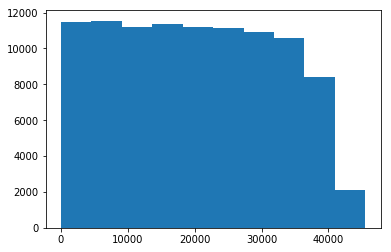

In [106]:
plt.hist(demands[:,-1]/alloc)
plt.show()